In [29]:
# Import packages
import pandas as pd
import numpy as np
import datetime
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, cohen_kappa_score, f1_score
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE, SMOTENC
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.decomposition import PCA
from scipy import stats
from math import sqrt



import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GaussianNoise
from keras.optimizers import SGD
from keras import regularizers

In [2]:
path = "/Users/Stijn/Documents/Master Data Science and Society/Block 3/thesis/code/thesis_Code/"
mood = pd.read_csv(path+'mood_imputed_median.csv', sep = ',', index_col=0)
mood['content_last'] = mood.groupby('user_id')['content'].shift()
mood.loc[(pd.isnull(mood.content_last)), 'content_last'] = mood['content']
mood_content = mood.drop(["anxious", "bored", "cheerful", "user_id", "response_time"], axis=1)

In [3]:
# Normalize predictors
mood_normz = mood_content.copy()
features_to_normalize = ['day_time_window', 'average_TimeUse', 'messaging', 'socialnetworking', 'otherapp']
mood_normz[features_to_normalize] = mood_normz[features_to_normalize].apply(lambda x:(x-x.min()) / (x.max()-x.min()))

In [4]:
# X = predictors, y = target
X = mood_normz.iloc[:,1:]
y = mood_normz.iloc[:, 0:1]

# Convert float to int
y = y.astype(int)

In [5]:
# Train (80%) & Test set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [6]:
# Oversampling unbalanced target
print("Before OverSampling, counts of labels: {}".format(y_train['content'].value_counts()))
  
sm = SMOTENC(categorical_features=[0, 2, 6], random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train['content'].ravel()) 

print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '2': {}".format(sum(y_train_res == 2))) 
print("After OverSampling, counts of label '3': {}".format(sum(y_train_res == 3))) 
print("After OverSampling, counts of label '4': {}".format(sum(y_train_res == 4))) 
print("After OverSampling, counts of label '5': {}".format(sum(y_train_res == 5))) 

Before OverSampling, counts of labels: 0    5139
1    1927
2    1840
3    1184
4     403
5      83
Name: bored, dtype: int64
After OverSampling, counts of label '0': 5139
After OverSampling, counts of label '1': 5139
After OverSampling, counts of label '2': 5139
After OverSampling, counts of label '3': 5139
After OverSampling, counts of label '4': 5139
After OverSampling, counts of label '5': 5139


In [7]:
# Convert oversample dataset to Pandas DataFrame
X_train = pd.DataFrame(data=X_train_res)
y_train = pd.DataFrame(data=y_train_res, columns=['content'])

In [8]:
# Binary Encoding
binary_encoder = ce.BinaryEncoder(cols = ['content'])
binary_encoder.fit(y_train)
y_train = binary_encoder.transform(y_train)
y_test = binary_encoder.transform(y_test)

In [9]:
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

In [10]:
X_train_nomood = X_train.iloc[:,:-1]
X_train_onlylastmood = X_train.iloc[:,-1:]
X_test_nomood = X_test.iloc[:,:-1]
X_test_onlylastmood = X_test.iloc[:,-1:]

In [11]:
# Define Keras model
model = Sequential()
model.add(Dense(24, input_dim=6, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(4, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                168       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 52        
Total params: 520
Trainable params: 520
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(X_train_nomood, y_train, epochs=100, validation_split=0.2, batch_size=512)

Train on 24667 samples, validate on 6167 samples
Epoch 1/100
24667/24667 [==============================] - 0s 13us/step - loss: 0.6880 - accuracy: 0.5622 - val_loss: 0.6704 - val_accuracy: 0.6291
Epoch 2/100
24667/24667 [==============================] - 0s 5us/step - loss: 0.6501 - accuracy: 0.6272 - val_loss: 0.6237 - val_accuracy: 0.6309
Epoch 3/100
24667/24667 [==============================] - 0s 5us/step - loss: 0.5967 - accuracy: 0.6261 - val_loss: 0.5681 - val_accuracy: 0.6285
Epoch 4/100
24667/24667 [==============================] - 0s 5us/step - loss: 0.5506 - accuracy: 0.6358 - val_loss: 0.5372 - val_accuracy: 0.6300
Epoch 5/100
24667/24667 [==============================] - 0s 5us/step - loss: 0.5313 - accuracy: 0.6352 - val_loss: 0.5271 - val_accuracy: 0.6268
Epoch 6/100
24667/24667 [==============================] - 0s 4us/step - loss: 0.5251 - accuracy: 0.6342 - val_loss: 0.5238 - val_accuracy: 0.6283
Epoch 7/100
24667/24667 [==============================] - 0s 5us/st

24667/24667 [==============================] - 0s 5us/step - loss: 0.5157 - accuracy: 0.6521 - val_loss: 0.5153 - val_accuracy: 0.6555
Epoch 57/100
24667/24667 [==============================] - 0s 4us/step - loss: 0.5154 - accuracy: 0.6529 - val_loss: 0.5153 - val_accuracy: 0.6557
Epoch 58/100
24667/24667 [==============================] - 0s 4us/step - loss: 0.5154 - accuracy: 0.6546 - val_loss: 0.5153 - val_accuracy: 0.6558
Epoch 59/100
24667/24667 [==============================] - 0s 4us/step - loss: 0.5154 - accuracy: 0.6528 - val_loss: 0.5153 - val_accuracy: 0.6560
Epoch 60/100
24667/24667 [==============================] - 0s 4us/step - loss: 0.5154 - accuracy: 0.6544 - val_loss: 0.5154 - val_accuracy: 0.6571
Epoch 61/100
24667/24667 [==============================] - 0s 4us/step - loss: 0.5153 - accuracy: 0.6536 - val_loss: 0.5153 - val_accuracy: 0.6528
Epoch 62/100
24667/24667 [==============================] - 0s 4us/step - loss: 0.5153 - accuracy: 0.6542 - val_loss: 0.5154 

In [13]:
score = model.evaluate(X_train_nomood, y_train, verbose=0)
print('Test loss:', round(score[0],4))
print('Test accuracy:', round(score[1]*100,2), "%")

Test loss: 0.5139
Test accuracy: 65.83 %


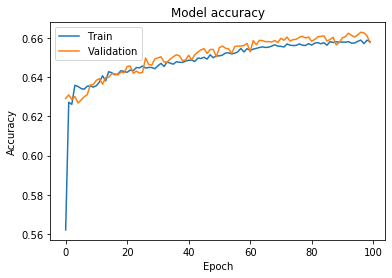

In [14]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

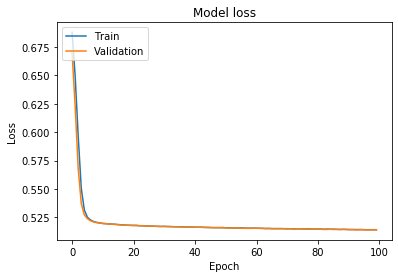

In [15]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
y_pred = model.predict(X_test_nomood)
binary_pred = []
for i in y_pred:
    temp_list = []
    for binary in i:
        if binary >= 0.5:
            temp_list.append(1)
        else:
            temp_list.append(0)
    binary_pred.append(temp_list)

binary_prediction = pd.DataFrame(data=binary_pred, columns=['content_0', 'content_1', 'content_2', 'content_3'])

In [17]:
len(binary_prediction)

2645

In [18]:
a = accuracy_score(binary_prediction, y_test)
print('Accuracy is:', a*100)

Accuracy is: 12.438563327032135


In [19]:
pred = []
for index, row in binary_prediction.iterrows():
    if row['content_0'] == 0:
        if row['content_1'] == 0:
            if row['content_2'] == 0:
                if row['content_3'] == 1:
                    pred.append(0)
                if row['content_3'] == 0:
                    pred.append(0)
            if row['content_2'] == 1:
                if row['content_3'] == 0:
                    pred.append(3)
                if row['content_3'] == 1:
                    pred.append(2)
        if row['content_1'] == 1:
            if row['content_2'] == 0:
                if row['content_3'] == 0:
                    pred.append(1)
                if row['content_3'] == 1:
                    pred.append(5)
            if row['content_2'] == 1:
                if row['content_3'] == 0:
                    pred.append(4)
                if row['content_3'] == 1:
                    pred.append(2)

In [20]:
len(pred)

2645

In [21]:
# Inverse y_test
test_df = binary_encoder.inverse_transform(y_test)
test = test_df['content'].tolist()

In [23]:
# true = y_test
# pred = y_pred
# last_value = X_bored_lastarray
same_correct = 0
same_wrong = 0
dif_correct = 0
dif_wrong = 0

X_test_bored = X_test_onlylastmood['content_last'].to_numpy()
for i in range(len(pred)):
    if (test[i] == X_test_bored[i]) and (test[i] == pred[i]):
        same_correct += 1
    if (test[i] == X_test_bored[i]) and (test[i] != pred[i]):
        same_wrong += 1
    if (test[i] != X_test_bored[i]) and (test[i] == pred[i]):
        dif_correct += 1
    if (test[i] != X_test_bored[i]) and (test[i] != pred[i]):
        dif_wrong += 1   

print("       ", "Same", "Dif")
print("correct", same_correct, dif_correct)
print("wrong  ", same_wrong, dif_wrong)

#Check if table is similar to accuracy
print("")
print("Accuracy of table is: ", ((same_correct+dif_correct) / (same_correct+dif_correct+same_wrong+dif_wrong)))
print("Accuracy of model is: ", a)

        Same Dif
correct 279 125
wrong   1502 739

Accuracy of table is:  0.15274102079395085
Accuracy of model is:  0.12438563327032136


In [24]:
from collections import Counter
print("Predicted valxues: ", Counter(pred))
print("True values: ", Counter(test))

Predicted valxues:  Counter({3: 917, 5: 658, 2: 486, 0: 372, 4: 208, 1: 4})
True values:  Counter({0: 1264, 1: 491, 2: 455, 3: 301, 4: 119, 5: 15})


In [25]:
same_correct_0, same_wrong_0, same_correct_1, same_wrong_1, same_correct_2, same_wrong_2, same_correct_3, same_wrong_3, same_correct_4, same_wrong_4, same_correct_5, same_wrong_5 = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
dif_correct_0, dif_wrong_0, dif_correct_1, dif_wrong_1, dif_correct_2, dif_wrong_2, dif_correct_3, dif_wrong_3, dif_correct_4, dif_wrong_4, dif_correct_5, dif_wrong_5 = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

for i in range(len(pred)):
    if test[i] == 0 and pred[i] == 0:
        if test[i] == X_test_bored[i]:
            same_correct_0 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_0 += 1
    if test[i] == 0 and pred[i] != 0:
        if test[i] == X_test_bored[i]:
            same_wrong_0 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_0 += 1

    if test[i] == 1 and pred[i] == 1:
        if test[i] == X_test_bored[i]:
            same_correct_1 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_1 += 1
    if test[i] == 1 and pred[i] != 1:
        if test[i] == X_test_bored[i]:
            same_wrong_1 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_1 += 1
        
    if test[i] == 2 and pred[i] == 2:
        if test[i] == X_test_bored[i]:
            same_correct_2 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_2 += 1
    if test[i] == 2 and pred[i] != 2:
        if test[i] == X_test_bored[i]:
            same_wrong_2 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_2 += 1
    
    if test[i] == 3 and pred[i] == 3:
        if test[i] == X_test_bored[i]:
            same_correct_3 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_3 += 1
    if test[i] == 3 and pred[i] != 3:
        if test[i] == X_test_bored[i]:
            same_wrong_3 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_3 += 1
        
    if test[i] == 4 and pred[i] == 4:
        if test[i] == X_test_bored[i]:
            same_correct_4 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_4 += 1
    if test[i] == 4 and pred[i] != 4:
        if test[i] == X_test_bored[i]:
            same_wrong_4 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_4 += 1
    
    if test[i] == 5 and pred[i] == 5:
        if test[i] == X_test_bored[i]:
            same_correct_5 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_5 += 1
    if test[i] == 5 and pred[i] != 5:
        if test[i] == X_test_bored[i]:
            same_wrong_5 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_5 += 1

print("Total length: ", len(X_test_bored))

print("Same Correct 0 guesses is: ", same_correct_0)
print("Same Wrong 0 guesses is: ", same_wrong_0)
print("Dif Correct 0 guesses is: ", dif_correct_0)
print("Dif Wrong 0 guesses is: ", dif_wrong_0)
print('')
print("Same Correct 1 guesses is: ", same_correct_1)
print("Same Wrong 1 guesses is: ", same_wrong_1)
print("Dif Correct 1 guesses is: ", dif_correct_1)
print("Dif Wrong 1 guesses is: ", dif_wrong_1)
print('')
print("Same Correct 2 guesses is: ", same_correct_2)
print("Same Wrong 2 guesses is: ", same_wrong_2)
print("Dif Correct 2 guesses is: ", dif_correct_2)
print("Dif Wrong 2 guesses is: ", dif_wrong_2)
print('')
print("Same Correct 3 guesses is: ", same_correct_3)
print("Same Wrong 3 guesses is: ", same_wrong_3)
print("Dif Correct 3 guesses is: ", dif_correct_3)
print("Dif Wrong 3 guesses is: ", dif_wrong_3)
print('')
print("Same Correct 4 guesses is: ", same_correct_4)
print("Same Wrong 4 guesses is: ", same_wrong_4)
print("Dif Correct 4 guesses is: ", dif_correct_4)
print("Dif Wrong 4 guesses is: ", dif_wrong_4)
print('')
print("Same Correct 5 guesses is: ", same_correct_5)
print("Same Wrong 5 guesses is: ", same_wrong_5)
print("Dif Correct 5 guesses is: ", dif_correct_5)
print("Dif Wrong 5 guesses is: ", dif_wrong_5)

Total length:  2645
Same Correct 0 guesses is:  159
Same Wrong 0 guesses is:  880
Dif Correct 0 guesses is:  40
Dif Wrong 0 guesses is:  185

Same Correct 1 guesses is:  0
Same Wrong 1 guesses is:  272
Dif Correct 1 guesses is:  0
Dif Wrong 1 guesses is:  219

Same Correct 2 guesses is:  40
Same Wrong 2 guesses is:  192
Dif Correct 2 guesses is:  40
Dif Wrong 2 guesses is:  183

Same Correct 3 guesses is:  80
Same Wrong 3 guesses is:  103
Dif Correct 3 guesses is:  37
Dif Wrong 3 guesses is:  81

Same Correct 4 guesses is:  0
Same Wrong 4 guesses is:  55
Dif Correct 4 guesses is:  5
Dif Wrong 4 guesses is:  59

Same Correct 5 guesses is:  0
Same Wrong 5 guesses is:  0
Dif Correct 5 guesses is:  3
Dif Wrong 5 guesses is:  12


In [27]:
mae_0, mae_1, mae_2, mae_3, mae_4, mae_5 = (0,0,0,0,0,0)

for i in range(len(pred)):
    if test[i] == 0 and pred[i] != 0:
        mae_0 += (abs(test[i]-pred[i]))
    if test[i] == 1 and pred[i] != 1:
        mae_1 += (abs(test[i]-pred[i]))
    if test[i] == 2 and pred[i] != 2:
        mae_2 += (abs(test[i]-pred[i]))
    if test[i] == 3 and pred[i] != 3:
        mae_3 += (abs(test[i]-pred[i]))
    if test[i] == 4 and pred[i] != 4:
        mae_4 += (abs(test[i]-pred[i]))
    if test[i] == 5 and pred[i] != 5:
        mae_5 += (abs(test[i]-pred[i]))

cnt_0, cnt_1, cnt_2, cnt_3, cnt_4, cnt_5 = (0,0,0,0,0,0)
for z in range(len(test)):
    if test[z] == 0:
        cnt_0 += 1
    if test[z] == 1:
        cnt_1 += 1
    if test[z] == 2:
        cnt_2 += 1
    if test[z] == 3:
        cnt_3 += 1
    if test[z] == 4:
        cnt_4 += 1
    if test[z] == 5:
        cnt_5 += 1

mae_macroaverage = ((mae_0/cnt_0) + (mae_1/cnt_1) + (mae_2/cnt_2) + (mae_3/cnt_3) + (mae_4/cnt_4) + (mae_5/cnt_5)) / 6

In [30]:
print("Macro-averaged Mean Absolute error is: ", round(mae_macroaverage, 4))
print("Macro-averaged F1-score is: ", round(f1_score(test, pred, average='weighted'), 4))

Macro-averaged Mean Absolute error is:  1.9629
Macro-averaged F1-score is:  0.1688
